In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Upload Required Files to Google Drive Shared Drive ###
import os
import shutil
from pathlib import Path

# Get current working directory (Colab extension mounts project folder)
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Define paths - use relative paths from current directory
LOCAL_BASE = Path(current_dir)
DRIVE_BASE = Path("/content/drive/Shareddrives/공유 문서함")

print("\n[Upload] Uploading required files to Google Drive Shared Drive...\n")

# 1. Upload Python modules
print("[1/4] Uploading Python modules...")
modules = ["dataloader.py", "config.py", "feature_extractor.py", "analysis.py", "error_case_analysis.py"]
uploaded_count = 0
for module in modules:
    src = LOCAL_BASE / module
    dst = DRIVE_BASE / module
    if src.exists():
        shutil.copy2(src, dst)
        print(f"  [OK] {module} ({src.stat().st_size / 1024:.1f} KB)")
        uploaded_count += 1
    else:
        print(f"  [WARN] {module} not found at {src}")

print(f"  Total: {uploaded_count}/{len(modules)} modules uploaded")

# 2. Upload HOG features
print("\n[2/4] Uploading HOG features...")
src_features = LOCAL_BASE / "features" / "hog-extended"
dst_features = DRIVE_BASE / "features" / "hog"

if src_features.exists():
    dst_features.mkdir(parents=True, exist_ok=True)
    
    npy_files = sorted(src_features.glob("*.npy"))
    total = len(npy_files)
    total_size = sum(f.stat().st_size for f in npy_files)
    
    print(f"  Found {total} .npy files ({total_size / (1024**2):.1f} MB)")
    print(f"  Uploading to: {dst_features}")
    
    for i, npy_file in enumerate(npy_files, 1):
        dst = dst_features / npy_file.name
        shutil.copy2(npy_file, dst)
        if i % 10 == 0 or i == total:
            print(f"  Progress: {i}/{total} files ({i/total*100:.1f}%)")
    
    print(f"  [OK] All {total} feature files uploaded successfully")
else:
    print(f"  [WARN] Local features not found at {src_features}")
    print(f"  Please make sure 'features/hog-extended' folder exists")

# 3. Create output directories
print("\n[3/4] Creating output directories...")
models_dir = DRIVE_BASE / "models"
results_dir = DRIVE_BASE / "results"
models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)
print(f"  [OK] {models_dir}")
print(f"  [OK] {results_dir}")

# 4. Verify uploaded files
print("\n[4/4] Verifying uploaded files...")
drive_modules = list(DRIVE_BASE.glob("*.py"))
drive_features = list(dst_features.glob("*.npy")) if dst_features.exists() else []
print(f"  Python modules in Drive: {len(drive_modules)}")
print(f"  Feature files in Drive: {len(drive_features)}")

print("\n[DONE] Upload complete! Ready to run training.")
print(f"\nFile structure in Google Drive:")
print(f"  공유 문서함/")
print(f"  |-- *.py ({len(drive_modules)} files)")
print(f"  |-- features/hog/ ({len(drive_features)} files)")
print(f"  |-- models/ (empty)")
print(f"  +-- results/ (empty)")


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Create directories in Google Drive Shared Drive
MODEL_DIR = '/content/drive/Shareddrives/공유 문서함/models'
RESULTS_DIR = '/content/drive/Shareddrives/공유 문서함/results'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✓ Models will be saved to: {MODEL_DIR}")
print(f"✓ Results will be saved to: {RESULTS_DIR}")

In [ ]:
import sys
# Add local Python modules from Drive
sys.path.append("/content/drive/Shareddrives/공유 문서함/")
# sys.path.append("archive/")  # For local execution

In [ ]:
from dataloader import load_hog_features, _train_test_split

# Use extended dataset from Google Drive Shared Drive
feature_dir = "/content/drive/Shareddrives/공유 문서함/features/hog"

X, y, class_names = load_hog_features(feature_dir=feature_dir, selected_classes=None, max_samples_per_class=None, shuffle=True, random_state=SEED)

X_train, y_train, X_test, y_test = _train_test_split(X, y, train_ratio=0.8, test_ratio=0.2, random_state=SEED, stratify=True)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print(f"Total samples: {len(X)}")
print(f"Classes: {len(class_names)}")

Train: (107520, 1764) (107520,)
Test: (26880, 1764) (26880,)


In [9]:
N_COMPONENTS = 256

pca = PCA(n_components=N_COMPONENTS, random_state=SEED)
pca.fit(X_train)

print("Explained variance ratio (sum):", pca.explained_variance_ratio_.sum())

X_train_pca = pca.transform(X_train)
X_test_pca  = pca.transform(X_test)

print("X_train_pca:", X_train_pca.shape)
print("X_test_pca: ", X_test_pca.shape)

Explained variance ratio (sum): 0.87386185
X_train_pca: (107520, 256)
X_test_pca:  (26880, 256)


In [10]:
### Logistic Regression ###

param_grid_logreg = {"C": [0.1, 1, 10]}

logreg = LogisticRegression(solver="lbfgs", n_jobs=-1, max_iter=200)
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=3, n_jobs=-1, verbose=2)
grid_logreg.fit(X_train_pca, y_train)

print("Best params (LogReg):", grid_logreg.best_params_)
print("Best CV score (LogReg):", grid_logreg.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params (LogReg): {'C': 1}
Best CV score (LogReg): 0.7896577380952382


In [ ]:
### SVM ###
# Note: SVM is very slow with large dataset (107,520 samples)
# Skipping for faster execution. Uncomment if needed.

# param_grid_svm = {"C": [0.1, 1, 10]}
# svc = SVC(probability=True, random_state=SEED)
# grid_svm = GridSearchCV(svc, param_grid_svm, cv=3, n_jobs=-1, verbose=2)
# grid_svm.fit(X_train_pca, y_train)
# print("Best params (SVM):", grid_svm.best_params_)
# print("Best CV score (SVM):", grid_svm.best_score_)

print("SVM training skipped (too slow with 107k samples)")

In [11]:
### K-NN ###

param_grid_knn = {"n_neighbors": [3, 5, 7]}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=3, n_jobs=-1, verbose=2)
grid_knn.fit(X_train_pca, y_train)

print("Best params:", grid_knn.best_params_)
print("Best CV score:", grid_knn.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'n_neighbors': 7}
Best CV score: 0.8226934523809524


In [12]:
### Random Forest ###

param_grid_rf = {"n_estimators": [25, 50, 75]}

rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_rf.fit(X_train_pca, y_train)

print("Best params:", grid_rf.best_params_)
print("Best CV score:", grid_rf.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'n_estimators': 75}
Best CV score: 0.6266369047619048


In [16]:
### Parameter Grid Search ###

def summarize_grid(grid, model_name, param_names):
    df = pd.DataFrame(grid.cv_results_)
    cols = [f"param_{p}" for p in param_names] + ["mean_test_score", "std_test_score", "rank_test_score"]
    df = df[cols].sort_values("rank_test_score")
    df.insert(0, "model", model_name)
    return df

df_logreg = summarize_grid(grid_logreg, "LogReg", ["C"])
df_knn = summarize_grid(grid_knn, "KNN", ["n_neighbors"])
df_rf = summarize_grid(grid_rf,  "RandomForest", ["n_estimators"])

display(df_logreg)
display(df_knn)
display(df_rf)

,model,param_C,mean_test_score,std_test_score,rank_test_score
1,LogReg,1.0,0.789658,0.000923,1
2,LogReg,10.0,0.785556,0.000447,2
0,LogReg,0.1,0.778460,0.001880,3


,model,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
2,KNN,7,0.822693,0.002099,1
1,KNN,5,0.819513,0.001623,2
0,KNN,3,0.801395,0.002229,3


,model,param_n_estimators,mean_test_score,std_test_score,rank_test_score
2,RandomForest,75,0.626637,0.003299,1
1,RandomForest,50,0.574498,0.002343,2
0,RandomForest,25,0.466657,0.003023,3


/tmp/ipython-input-1667987536.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, ax=ax, palette="Blues")


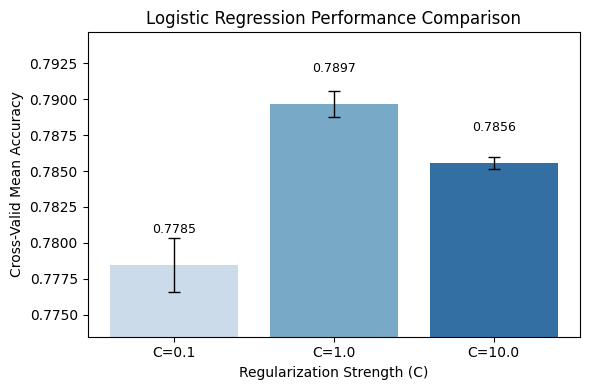

In [55]:
### Logistic Regression Performance Comparison between Parameters ###

df_logreg_plot = df_logreg.sort_values("param_C")

labels = [f"C={c}" for c in df_logreg_plot["param_C"]]
x = np.arange(len(df_logreg_plot))
y = df_logreg_plot["mean_test_score"]
yerr = df_logreg_plot["std_test_score"]

fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(x=x, y=y, ax=ax, palette="Blues")

# error bar
ax.errorbar(
    x, y,
    yerr=yerr,
    fmt="none",
    ecolor="black",
    capsize=4,
    linewidth=1,
)

margin = 0.005
ax.set_ylim(y.min() - margin, y.max() + margin)

for i, v in enumerate(y):
    ax.text(i, v + margin * 0.4, f"{v:.4f}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_title("Logistic Regression Performance Comparison")
ax.set_xlabel("Regularization Strength (C)")
ax.set_ylabel("Cross-Valid Mean Accuracy")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1086577211.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette="Greens")


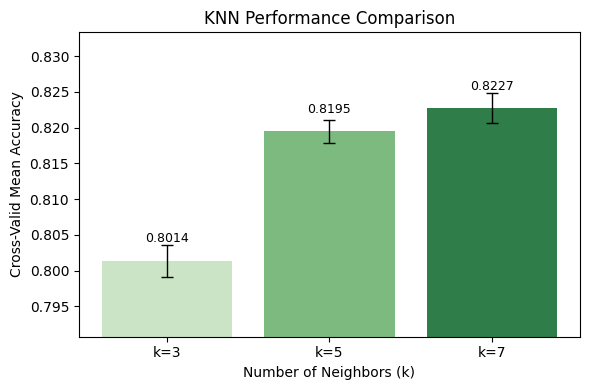

In [45]:
### KNN Performance Comparison between Parameters ###

df_knn_plot = df_knn.sort_values("param_n_neighbors")

x = np.arange(len(df_knn_plot))
y = df_knn_plot["mean_test_score"].values
yerr = df_knn_plot["std_test_score"].values
labels = [f"k={k}" for k in df_knn_plot["param_n_neighbors"]]

y_min, y_max = y.min(), y.max()
MARGIN_FACTOR = 0.5
margin = (y_max - y_min) * MARGIN_FACTOR or 0.001

plt.figure(figsize=(6, 4))
sns.barplot(x=x, y=y, palette="Greens")

plt.errorbar(
    x, y,
    yerr=yerr,
    fmt="none",
    ecolor="black",
    capsize=4,
    linewidth=1,
)

plt.ylim(max(0, y_min - margin), min(1, y_max + margin))

for i, v in enumerate(y):
    plt.text(i, v + margin * 0.2, f"{v:.4f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, labels)
plt.title("KNN Performance Comparison")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Valid Mean Accuracy")
plt.tight_layout()
plt.show()

/tmp/ipython-input-821945232.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x, y=y, palette="Oranges")


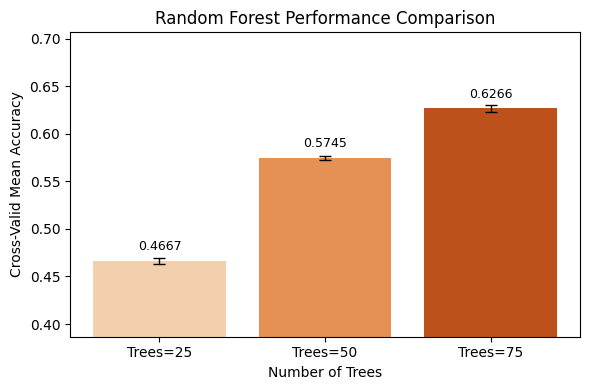

In [43]:
### RF Performance Comparison between Parameters ###

df_rf_plot = df_rf.sort_values("param_n_estimators")

x = np.arange(len(df_rf_plot))
y = df_rf_plot["mean_test_score"].values
yerr = df_rf_plot["std_test_score"].values
labels = [f"Trees={n}" for n in df_rf_plot["param_n_estimators"]]

y_min, y_max = y.min(), y.max()
MARGIN_FACTOR = 0.5
margin = (y_max - y_min) * MARGIN_FACTOR or 0.001

plt.figure(figsize=(6, 4))
sns.barplot(x=x, y=y, palette="Oranges")

plt.errorbar(
    x, y,
    yerr=yerr,
    fmt="none",
    ecolor="black",
    capsize=4,
    linewidth=1,
)

plt.ylim(max(0, y_min - margin), min(1, y_max + margin))

for i, v in enumerate(y):
    plt.text(i, v + margin * 0.1, f"{v:.4f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, labels)
plt.title("Random Forest Performance Comparison")
plt.xlabel("Number of Trees")
plt.ylabel("Cross-Valid Mean Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
### ACC/F1/Precision/Recall Comparison ###

def evaluate(model, X, y):
    pred = model.predict(X)
    return {
        "accuracy": accuracy_score(y, pred),
        "precision_macro": precision_score(y, pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y, pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y, pred, average="macro", zero_division=0),
    }

best_models = {
    "LogReg": grid_logreg.best_estimator_,
    "KNN": grid_knn.best_estimator_,
    "RandomForest": grid_rf.best_estimator_,
}

rows = []
for name, clf in best_models.items():
    metrics = evaluate(clf, X_test_pca, y_test)
    metrics["model"] = name
    rows.append(metrics)

df_metrics = pd.DataFrame(rows).set_index("model")
print("\nModel Performance Metrics:")
display(df_metrics)

# Save metrics
metrics_path = f'{RESULTS_DIR}/model_comparison_metrics.csv'
df_metrics.to_csv(metrics_path)
print(f"\n✓ Saved: {metrics_path}")

,accuracy,precision_macro,recall_macro,f1_macro
model,,,,
LogReg,0.798251,0.798640,0.798251,0.798059
KNN,0.846466,0.852945,0.846466,0.847406
RandomForest,0.661347,0.665848,0.661347,0.659436


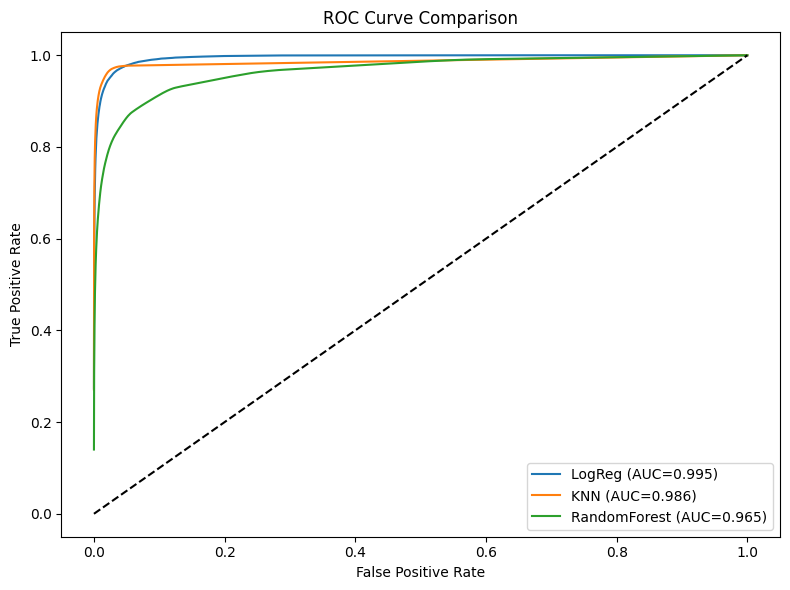

In [21]:
### ROC Curve ###

n_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

plt.figure(figsize=(8, 6))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_pca)
    else:
        y_score = model.decision_function(X_test_pca)

    fpr = {}
    tpr = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC={auc_macro:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
### Save All Trained Models ###

print("Saving trained models...")

# Save PCA
joblib.dump(pca, f'{MODEL_DIR}/pca.pkl')
print(f"✓ Saved: {MODEL_DIR}/pca.pkl")

# Save best estimators
joblib.dump(grid_logreg.best_estimator_, f'{MODEL_DIR}/logistic_regression.pkl')
print(f"✓ Saved: {MODEL_DIR}/logistic_regression.pkl (C={grid_logreg.best_params_['C']})")

joblib.dump(grid_knn.best_estimator_, f'{MODEL_DIR}/knn.pkl')
print(f"✓ Saved: {MODEL_DIR}/knn.pkl (k={grid_knn.best_params_['n_neighbors']})")

joblib.dump(grid_rf.best_estimator_, f'{MODEL_DIR}/random_forest.pkl')
print(f"✓ Saved: {MODEL_DIR}/random_forest.pkl (n_estimators={grid_rf.best_params_['n_estimators']})")

# Save GridSearchCV objects (for full results)
joblib.dump(grid_logreg, f'{MODEL_DIR}/grid_logreg.pkl')
joblib.dump(grid_knn, f'{MODEL_DIR}/grid_knn.pkl')
joblib.dump(grid_rf, f'{MODEL_DIR}/grid_rf.pkl')

print("\n✓ All models saved successfully!")
print(f"  - Total files: 7")
print(f"  - Location: {MODEL_DIR}/")

# Save class names for inference
np.save(f'{MODEL_DIR}/class_names.npy', class_names)
print(f"✓ Saved: {MODEL_DIR}/class_names.npy")
